In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system
dir_curr = Path('depreciated/spikes/')
vol_file = Path('depreciated/analysis_sections_based_on_swim_pattern.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

In [3]:
from utils import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums

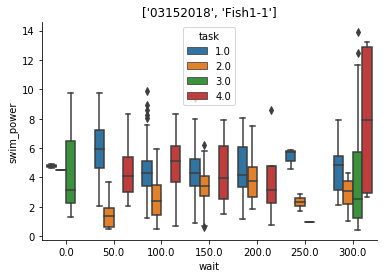

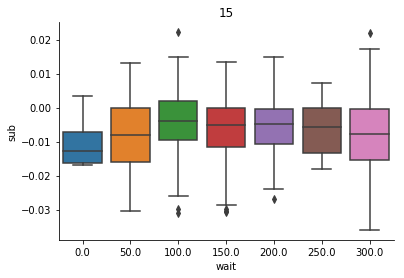

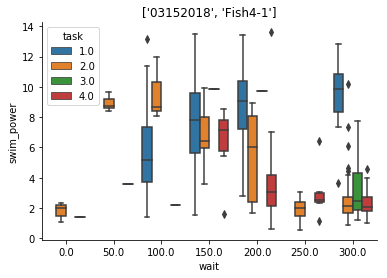

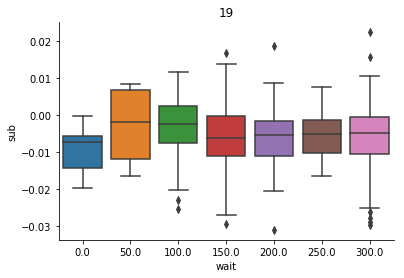

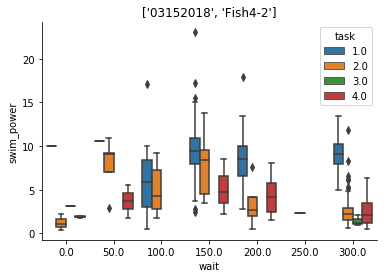

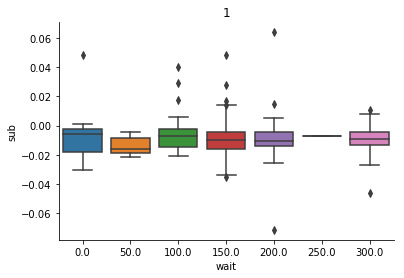

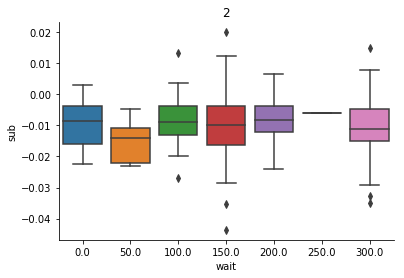

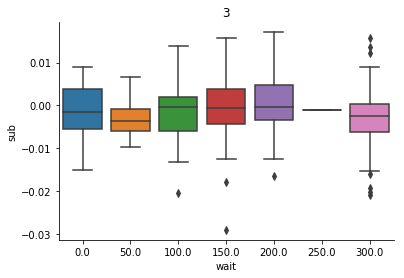

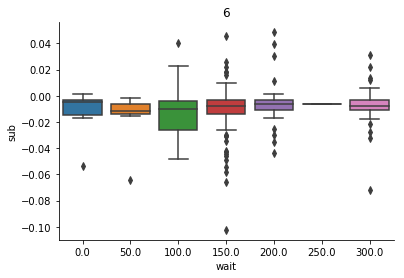

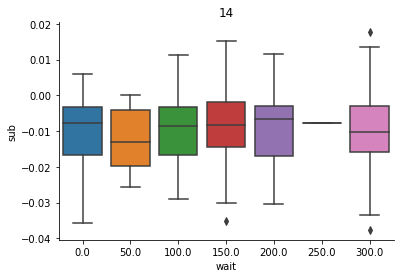

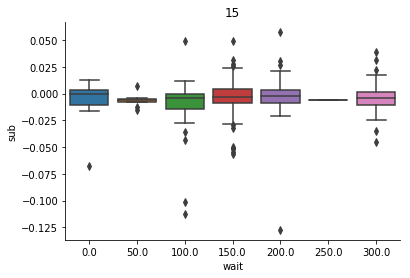

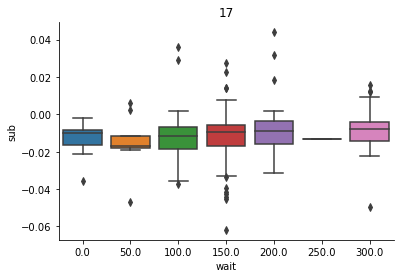

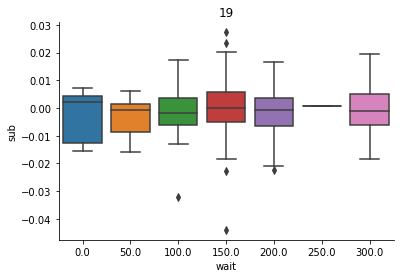

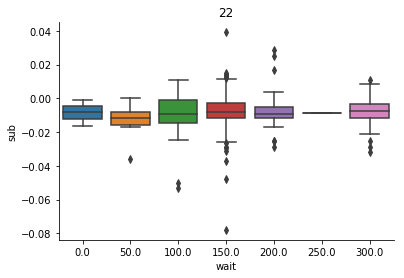

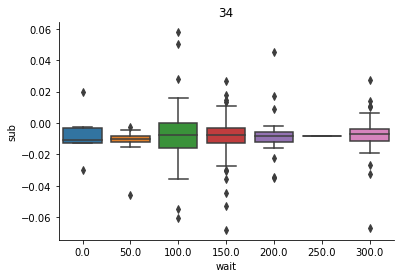

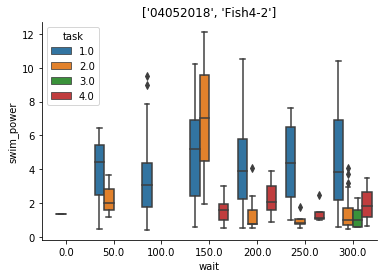

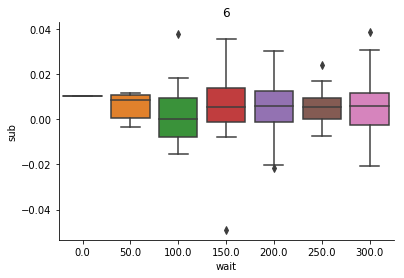

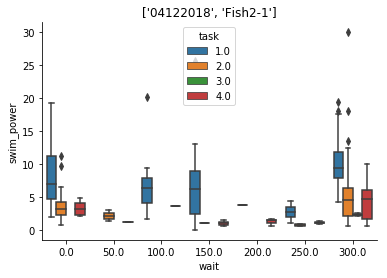

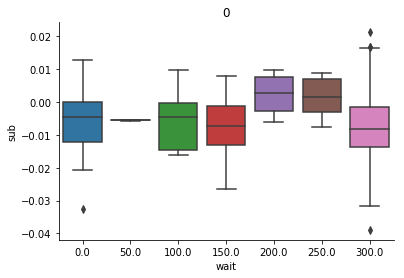

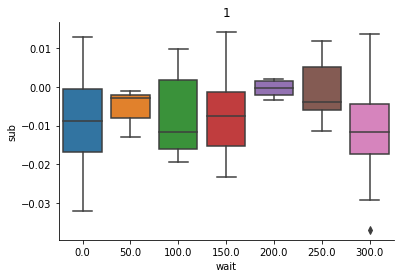

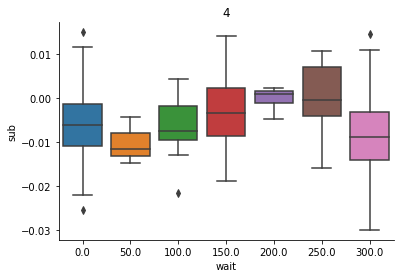

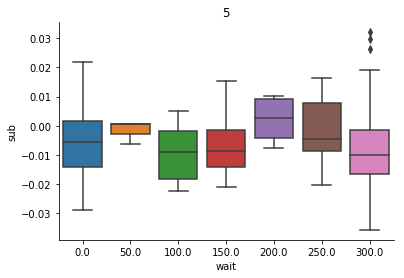

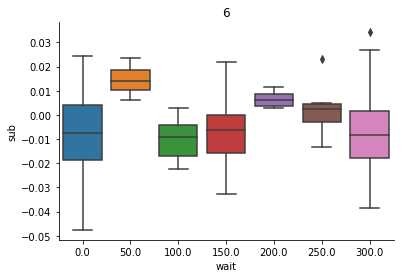

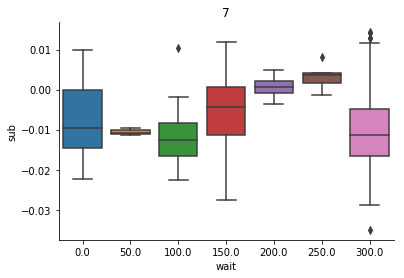

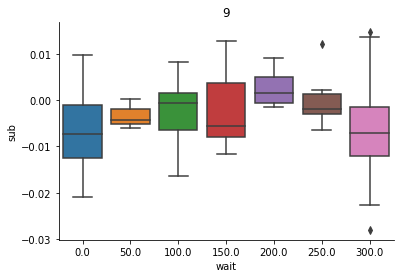

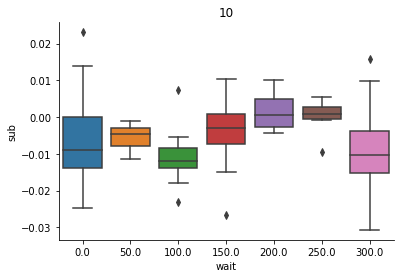

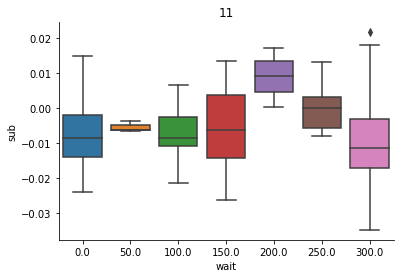

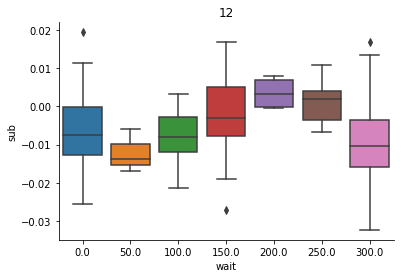

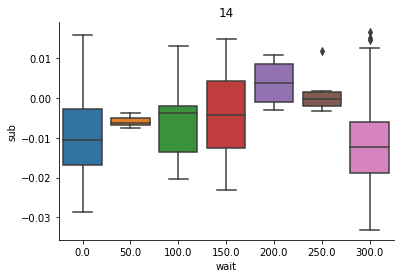

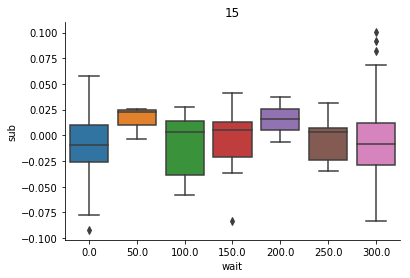

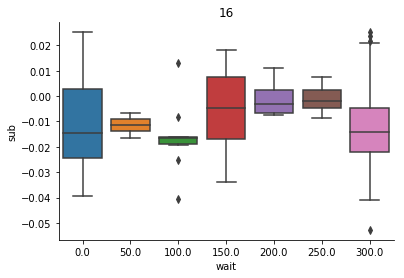

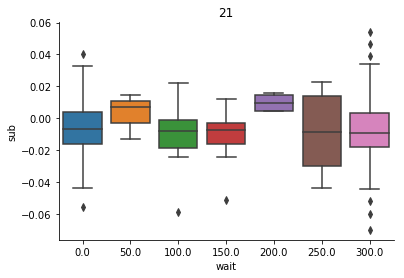

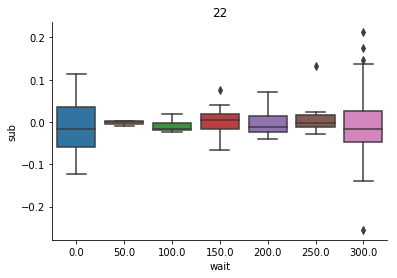

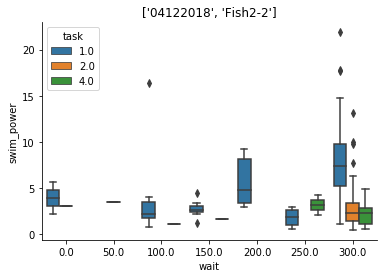

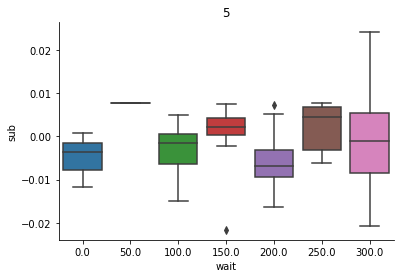

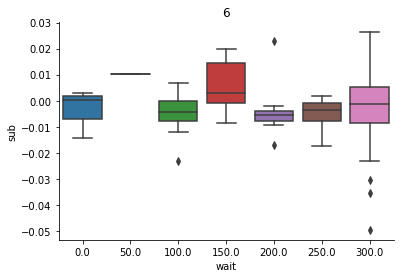

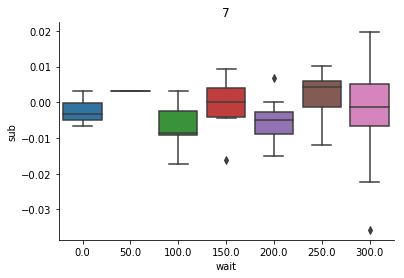

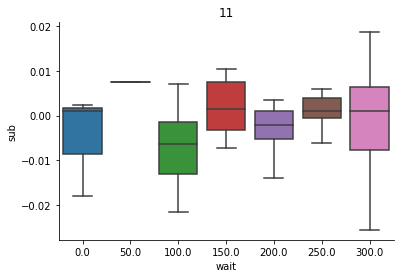

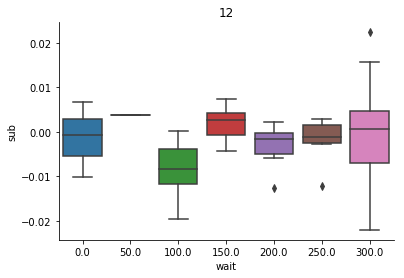

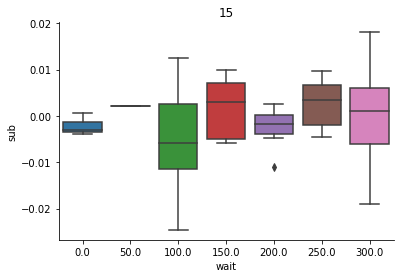

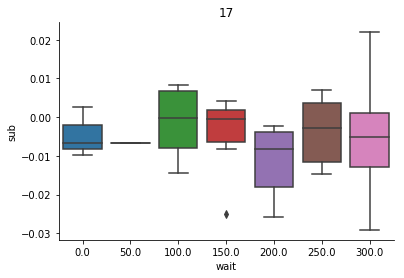

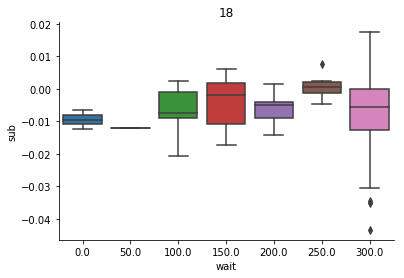

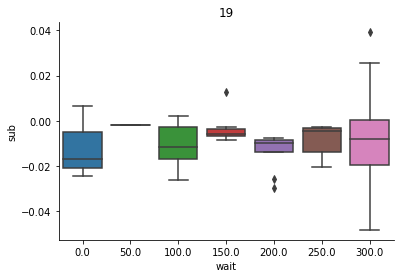

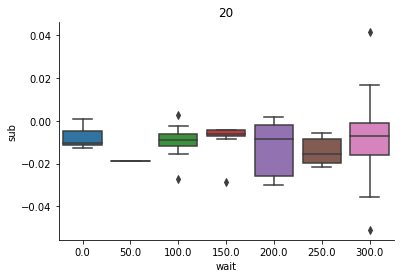

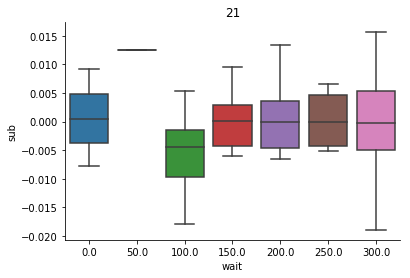

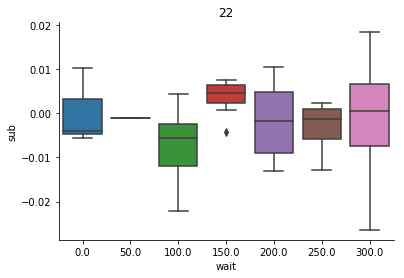

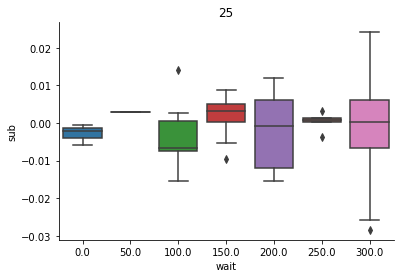

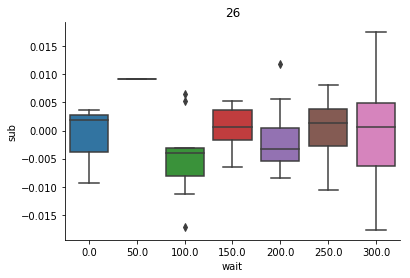

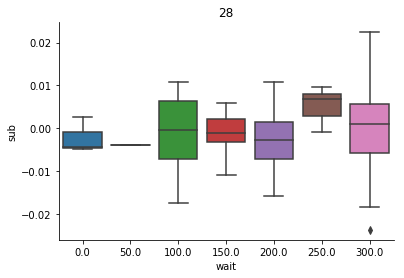

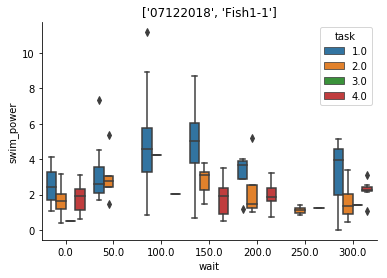

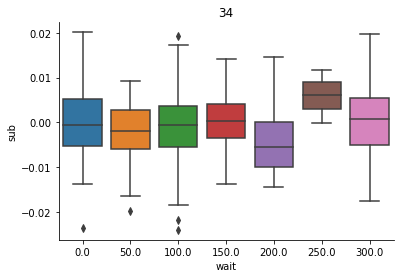

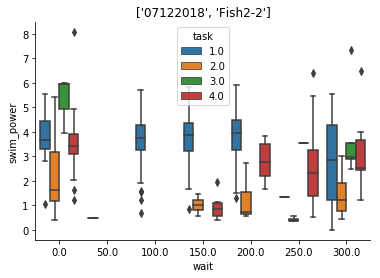

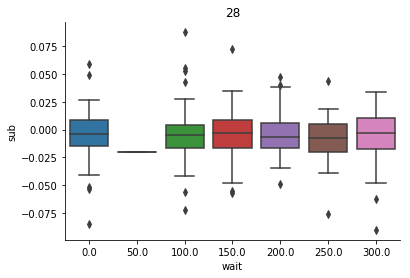

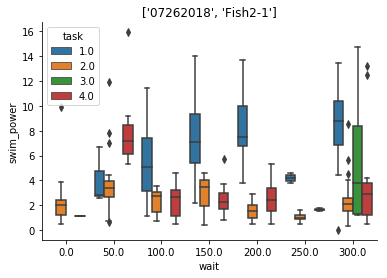

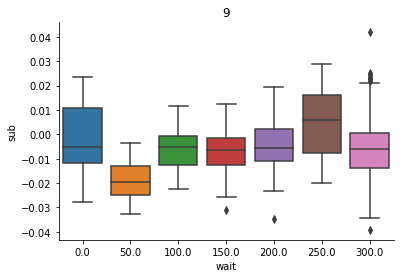

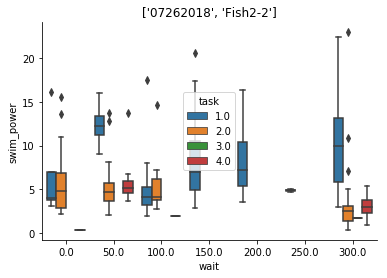

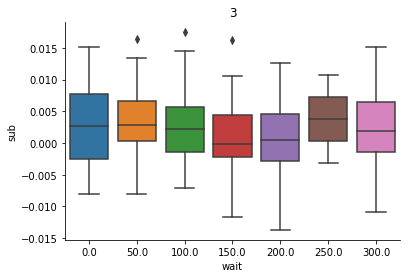

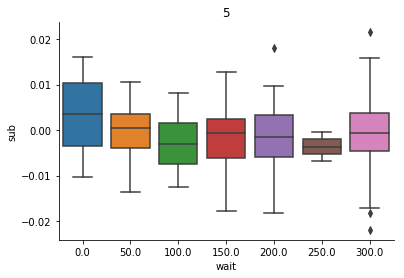

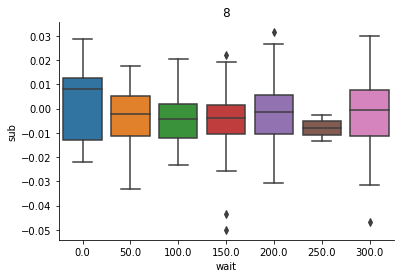

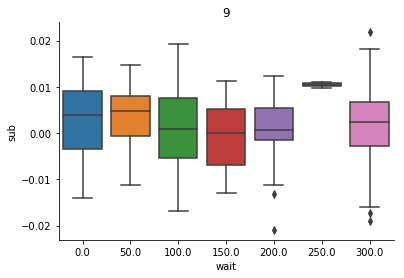

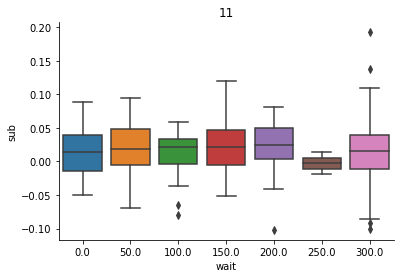

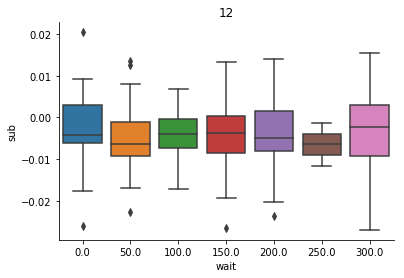

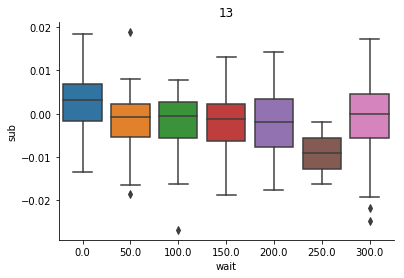

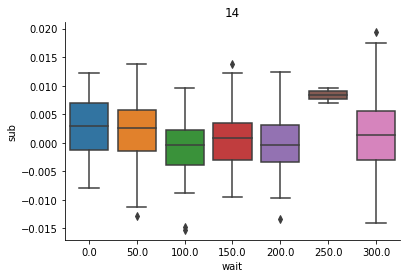

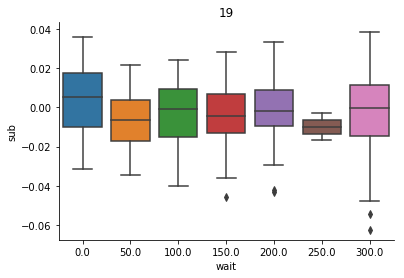

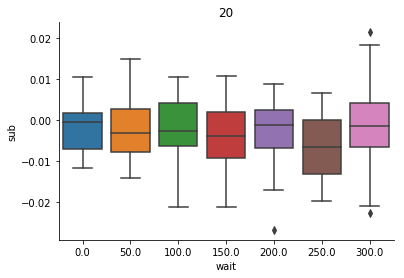

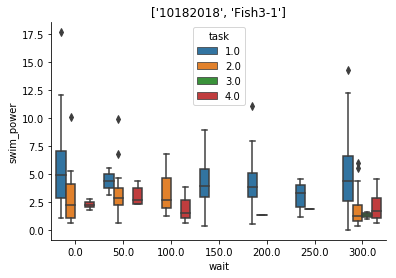

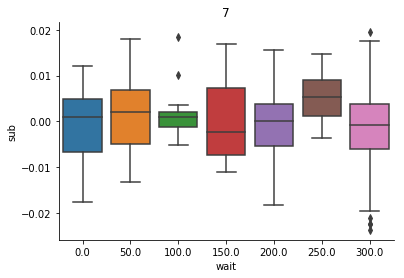

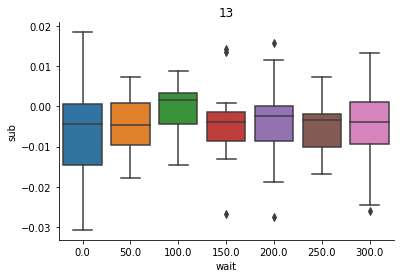

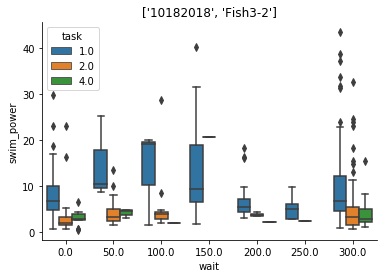

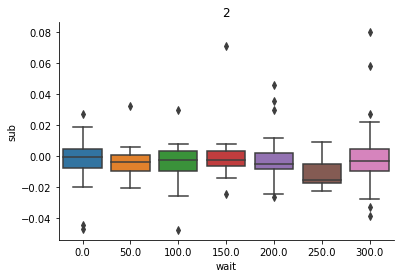

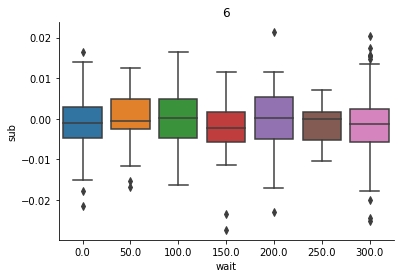

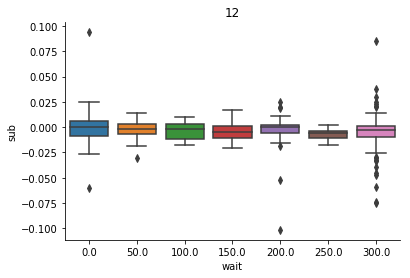

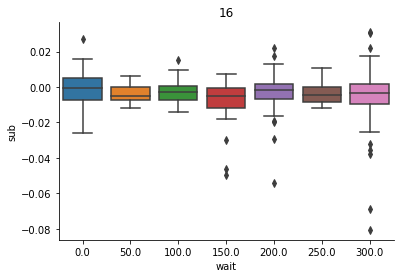

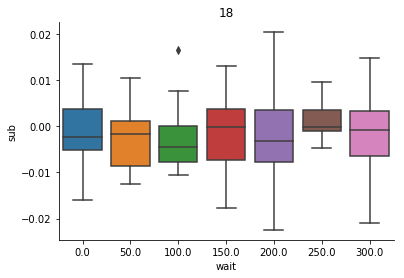

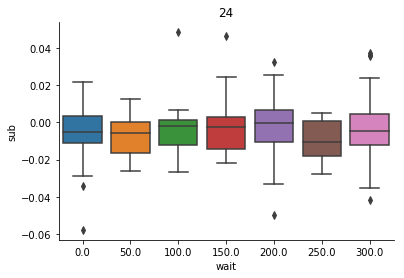

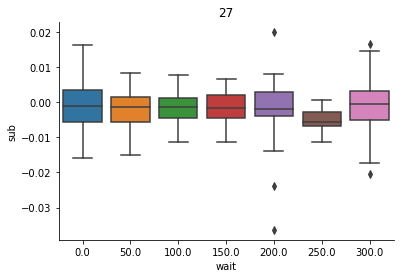

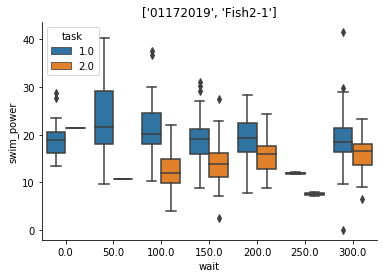

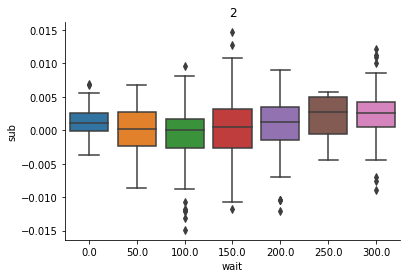

In [28]:
for _, row in dat_xls_file.iterrows():
    if 'Social' in row['task']:
        continue
    if 'Optovin' in row['task']:
        continue
    folder = row['folder']
    fish = row['fish']
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
    dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
    spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
    num_cell = spk.shape[0]
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')

    _ = np.load(f'swim_power/{folder}_{fish}_swim_dat.npz')
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    visu = _['visu']
    task_period = _['task_period']
    swim_task_index = _['swim_task_index']
    p_swim = np.sqrt(r_swim**2+l_swim**2)

    n_task = task_period.max().astype('int')
    swim_task_index_ = (swim_task_index-1)%n_task+1
    swim_bout_index_task = np.zeros(len(swim_task_index_)).astype('int')
    swim_bout_index_task[0] = 1
    for n_bout in range(len(swim_task_index_)-1):
        if swim_task_index_[n_bout] == swim_task_index_[n_bout-1]:
            swim_bout_index_task[n_bout] = swim_bout_index_task[n_bout-1]+1
        else:
            swim_bout_index_task[n_bout] = 1

    swim_bout_index_task = swim_bout_index_task
    
    subvolt = dff.copy()
    k_filter = 30
    
    t_wait = np.empty(r_swim.shape[0])
    t_wait[:] = np.nan
    for n, n_swim in enumerate(swim_starts):
        t_wait[n] = np.diff(np.where(p_swim[n]>0)[0]).max()
        if t_wait[n] == 1:
            t_wait[n] = 310
            
    p_swim_ave = p_swim[:, 50:110].mean(axis=-1)
    p_swim_ave = p_swim[:, 50:110].mean(axis=-1)
    t_wait_ = t_wait//50*50
    power_list = pd.DataFrame(list(zip(p_swim_ave, t_wait_, task_period)), columns=['swim_power', 'wait', 'task'])
    
#     p_swim_wait = []
#     for n in range(7):
#         valid_ind = (t_wait>n*50) & (t_wait<=n*50+50)
#         p_low = p_swim[valid_ind & (task_period==1), 50:110].mean()
#         p_high = p_swim[valid_ind & (task_period==2), 50:110].mean()
#         p_swim_wait.append([p_low, p_high])

    plot_power = True
    
    for n_cell, ndff in enumerate(dff):
        if spk[n_cell].sum()<100:
            continue
        subvolt[n_cell, :] = medfilt(ndff, kernel_size=k_filter*2+1)
        sub_list = np.zeros((r_swim.shape[0], 400))
        sub_list[:] = np.nan
        for n, n_swim in enumerate(swim_starts):
            if (n_swim>100) and (n_swim+300<len(subvolt[n_cell])):
                sub_list[n, :] = subvolt[n_cell, n_swim-100:n_swim+300] 
                sub_list[n, :] = sub_list[n, :] - sub_list[n, 70:100].mean()
        t_min = 0
        t_max = 400
        ave_low = sub_list[(task_period==1) & (t_wait==310), :]*100
        ave_high = sub_list[(task_period==2) & (t_wait==310), :]*100
        if (ave_low.shape[0]==0) or (ave_high.shape[0]==0):
            continue
        n_p = np.zeros(400)
        for _ in range(400):
            __, n_p[_] = ranksums(ave_low[:, _], ave_high[:, _])
        if (n_p[100:]<0.05).mean()<0.4:
            continue

        sub_ave_list = pd.DataFrame(list(zip(sub_list_ave_, t_wait_, task_period)), columns=['sub', 'wait', 'task'])
        
        if plot_power:
            sns.boxplot(x='wait', y='swim_power', hue='task', data=power_list)
            plt.title([folder, fish])
            sns.despine()
            plt.show()
            plot_power = False
        
        s_ = sub_ave_list[sub_ave_list['task']==1]
        mean_ = s_.groupby(['wait']).mean()
        sns.boxplot(x='wait', y='sub', data=sub_ave_list)
        sns.despine()
        plt.title(n_cell)
        plt.show()
        

In [33]:
s_ = sub_ave_list[sub_ave_list['task']==1]
mean_ = s_.groupby(['wait']).mean()

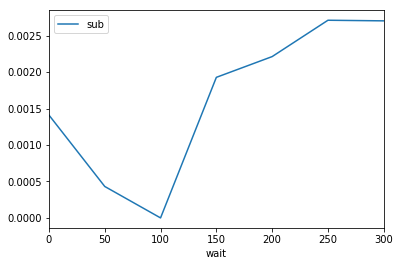

In [42]:
mean_.plot(y='sub')

In [40]:
mean_

,sub,task
wait,,
0.0,1.410797e-03,1.0
50.0,4.318611e-04,1.0
100.0,4.558876e-07,1.0
150.0,1.928375e-03,1.0
200.0,2.213032e-03,1.0
250.0,2.711506e-03,1.0
300.0,2.703139e-03,1.0
